# Telegram Bot

The final part of this study is to wrap the whole pipeline into some usable "app".

We'll create a telegram bot that will receive photos and try to recognise all people on these photos.

Large fuctions are located in custom_models.py.

In [1]:
from custom_models import FaceRegressionModel, FaceRecognitionModel, FaceFinder

Other imports

In [2]:
import uuid
import torch
import time
import requests
import PIL
import pandas as pd
import os
import numpy as np
import nest_asyncio
import matplotlib.pyplot as plt
import logging
import json
import io
import cv2
import albumentations as A
from torch import nn
from sklearn.preprocessing import normalize
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from PIL import Image
from io import BytesIO
from albumentations.pytorch import ToTensorV2
from aiogram import Bot, Dispatcher, executor, types
nest_asyncio.apply()

Set verbosity.

In [3]:
verb = False

def print_v(text):
    if verb: print(text)

Set logging level.

In [4]:
logging.basicConfig(level=logging.WARNING)
logger = logging.getLogger(__name__)

Token is saved outside the project folder. Let's get it.

In [5]:
if 'nt' in os.name:
    path_file = 'path_windows.txt'
else:
    path_file = 'path_linux.txt'
tmp_dir = 'tmp/'

In [6]:
path_to_token = open(path_file, 'r')
path_to_token = path_to_token.readlines()[0].rstrip('\n')
path_to_token = open(path_to_token, 'r')
API_TOKEN = path_to_token.readlines()[0].rstrip('\n')

Create face finder class.

In [7]:
face_finder = FaceFinder(
    detector_weights_path='./models/detection/best.pt',
    regressor_model_path='./models/landmark/best_landmark_model.pt',
    regressor_config_path='./models/landmark/best_landmark_model_cfg.txt',
    recognitor_model_path='./models/recognition/best_recog_model_arc.pt',
    recognitor_config_path='./models/recognition/best_model_cfg.txt',
    landmark_path='./tables/final_landmarks_small.pkl',
    embed_path='./tables/embed_arc.npy',
    custom_params_recognition_path='./models/recognition/custom_params.txt',
    device='cpu'
)

Downloading: "https://github.com/ultralytics/yolov5/archive/master.zip" to /home/sergey/.cache/torch/hub/master.zip
INFO:yolov5:YOLOv5 🚀 2022-7-15 Python-3.9.7 torch-1.11.0+cu113 CPU

YOLOv5 🚀 2022-7-15 Python-3.9.7 torch-1.11.0+cu113 CPU

INFO:yolov5:Fusing layers... 
Fusing layers... 
INFO:yolov5:Model summary: 213 layers, 7012822 parameters, 0 gradients
Model summary: 213 layers, 7012822 parameters, 0 gradients
INFO:yolov5:Adding AutoShape... 
Adding AutoShape... 


Test the model.

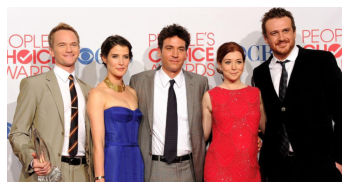

In [8]:
%matplotlib inline
test_image1 = 'https://media.distractify.com/brand-img/jpUq_p_H2/0x0/h-i-m-y-m-1642437794785.jpg' 
test_image1 = Image.open(requests.get(test_image1, stream=True).raw)
plt.figure()
plt.imshow(test_image1)
plt.axis('off')
plt.show()

CPU times: user 2.98 s, sys: 304 ms, total: 3.28 s
Wall time: 1.81 s


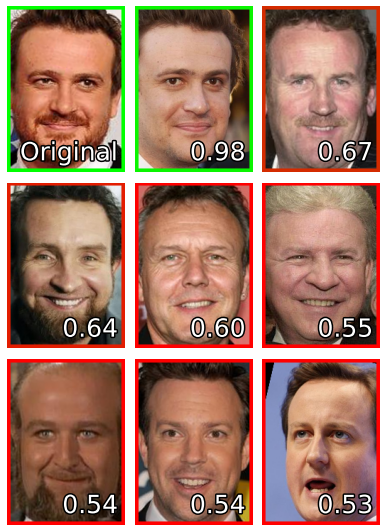

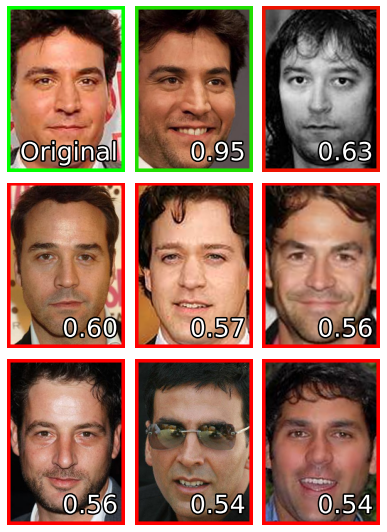

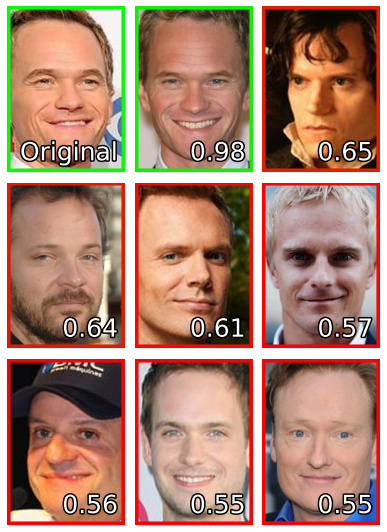

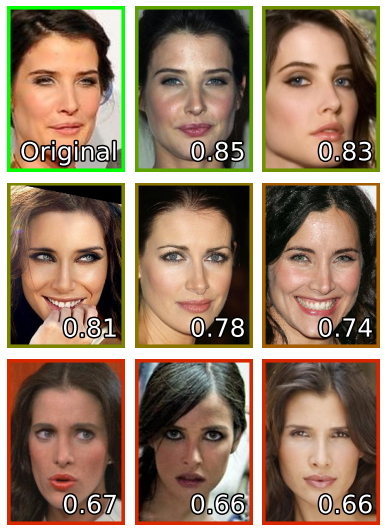

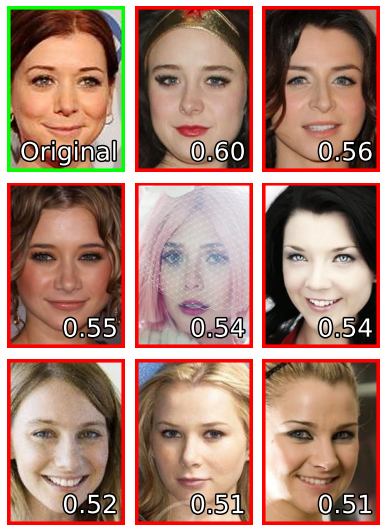

In [9]:
%%time
faces = face_finder.find_faces(img=test_image1)

Create "empty" bot.

In [10]:
bot = Bot(token=API_TOKEN)
dp = Dispatcher(bot)

"Welcome" message handler.

In [11]:
@dp.message_handler(commands=['start', 'help'])
async def start(message: types.Message):
    print_v('received start command')
    text = 'Hi! Please send photo with some faces.'
    text += ' This bot will find some celebrities that look like people on the photo!'
    await bot.send_message(message.chat.id, text=text)

Any text message handler.

In [12]:
@dp.message_handler(content_types=types.ContentTypes.TEXT)
async def handle_text_message(message: types.Message):
    print_v('text received')
    chat_id = message.chat.id
    print_v('chat_id', chat_id)
    text = message.text
    print_v('message.text', text)
    if text:
        print('replying')
        await bot.send_message(chat_id, text='Please send photo with some faces!')

Photo message handler. The magic happens here.

In [13]:
@dp.message_handler(content_types=types.ContentTypes.PHOTO)
async def handle_docs_photo(message: types.Message):
    # get almost unique value
    unique_id = uuid.uuid4().hex
    print_v('photo received')
    
    # create file name
    chat_id = message.chat.id
    fname = tmp_dir + str(chat_id) + '_' + unique_id + '.jpg'
    print_v(fname)
    
    # download and save photo
    await message.photo[-1].download(destination_file=fname)
    print_v('photo saved')
    
    # read photo
    image = cv2.imread(fname)
    print_v('photo read')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    print_v('photo converted')
    
    # find faces, save them to results variable
    results = face_finder.find_faces(img=image)
    print_v('faces found')
    print_v(len(results))
    
    # send message with number of faces
    if len(results) != 1:
        text = f'found {len(results)} faces:'
        await bot.send_message(chat_id=chat_id, text=text)
    
    for i, r in enumerate(results):
        # new temp file name
        unique_id = uuid.uuid4().hex
        fname_res = tmp_dir + str(chat_id) + '_' + unique_id + '_res' + str(i) + '.png'
        
        # send message with face number
        text = ''
        if len(results) > 1:
            text = f'face #{i+1}'
        
        print_v(r['message'])
        # send "bad face" message
        if r['message'] == 'rotated face':
            text += 'the face is turned too much:'
        elif r['message'] == 'small face':
            text += 'the face is too small:'
        print_v(text)
        if len(text) > 0:
            await bot.send_message(chat_id=chat_id, 
                                   text=text)
        
        # show image
        if r['image'] != None:
            r['image'].save(fname_res)
            print_v('tmp file saved')
            with open(fname_res, 'rb') as f_open:
                await bot.send_photo(chat_id=chat_id, photo=f_open)
            print_v('image sent')
            
            # delete temp file
            os.remove(fname_res)
            print_v('tmp file deleted')
            
    os.remove(fname)

Make tmp dir to save images.

In [14]:
try: os.mkdir('tmp')
except: pass

Aaaaaand execute!

INFO:aiogram:Bot: doctor_test_bot [@expline_bot]
Bot: doctor_test_bot [@expline_bot]
Updates were skipped successfully.
INFO:aiogram.dispatcher.dispatcher:Start polling.
Start polling.
INFO:aiogram.dispatcher.dispatcher:Stop polling...
Stop polling...
Goodbye!


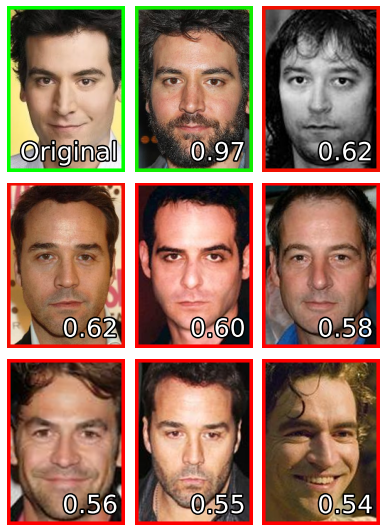

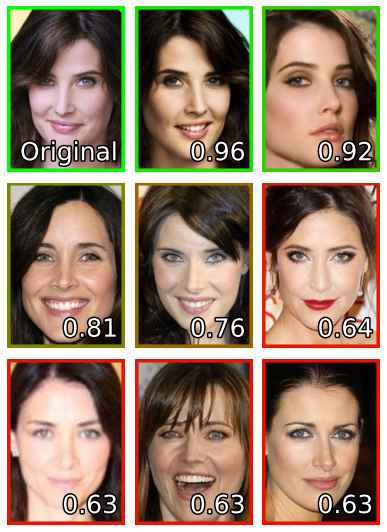

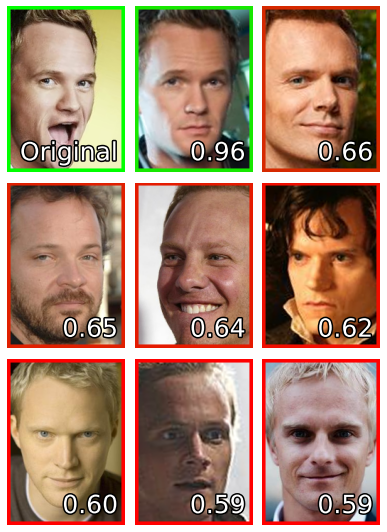

In [15]:
executor.start_polling(dp, skip_updates=True)